### Rede Neural Convolucional (Convolutional Neural Network-CNN)
### Classificação de Imagens

In [24]:
# Imports
from keras.models import Sequential
from keras.layers import (Conv2D,MaxPooling2D, Flatten, BatchNormalization,
                         Dropout,Dense)
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

In [25]:
#Nós então inicializamos a nossa rede
classifier = Sequential()

Agora nós definimos os parâmetros para o shape dos dados de entrada e a função de ativação. Usaremos 32 features para um array 2D e definiremos nosso array como o formato 3x3.

Converteremos todas as nossas imagens 64x64 pixels em um array 3D (pois as imagens são coloridas com 3 canais de cores). 

In [26]:
# Passo 1 - Primeira Camada de Convolução - pré-processamento da rede
#O recomendado é com 64
#Uma matriz de 9 pixel para fazer a multiplicação(3, 3)
#Altura e largura da imagem e os três canais RGB(64, 64, 3)
#Eu posso começar com 32, mas 64 é legal. Vai deixar todas as imagens de entrada
#Com 64 pixel. Pode colocar maior, mas depende do tamnho das imagens e do computador
classifier.add(Conv2D(64, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))

In [27]:
#Normalização entre 0 e 1
classifier.add(BatchNormalization())

Agora aplicamos o agrupamento (pooling) para reduzir o tamanho do mapa de features resultado da primeira camada de convolução (dividido por 2):

In [28]:
# Passo 2 - Pooling - pré-processamento da rede
classifier.add(MaxPooling2D(pool_size = (2, 2)))

Adicionamos então a Segunda Camada de Convolução, tornando nossa rede um pouco mais profunda:

In [29]:
# Adicionando a Segunda Camada de Convolução - pré-processamento da rede
classifier.add(Conv2D(32, (3, 3), activation = 'relu'))

In [30]:
#Normalização entre 0 e 1
classifier.add(BatchNormalization())

Mais uma vez, aplicamos a camada de pooling à saída da camada de convolução anterior.

In [31]:
classifier.add(MaxPooling2D(pool_size = (2, 2)))

In [32]:
# Passo 3 - Flattening - pré-processamento da rede
classifier.add(Flatten())

No próximo passo conectamos todas as camadas. Usamos uma função de ativação retificadora (relu) e então uma função de ativação sigmóide para obter as probabilidades de cada imagem conter um cachorro ou um gato. O modelo raramente terá 100% de certeza e o que ele gera como um resultado é uma probabilidade.

In [33]:
#Passo 4 - Full connection - Montando a rede neural densa
classifier.add(Dense(units = 128, activation = 'relu'))
#Vou zerar 20% das entradas
classifier.add(Dropout(0.2))
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dropout(0.2))
classifier.add(Dense(units = 1, activation = 'sigmoid'))

In [34]:
classifier.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 62, 62, 64)        1792      
_________________________________________________________________
batch_normalization_4 (Batch (None, 62, 62, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 29, 29, 32)        18464     
_________________________________________________________________
batch_normalization_5 (Batch (None, 29, 29, 32)        128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)             

Finalmente nós compilamos nossa rede neural. Para compilar a rede, usamos o otimizador "Adam", um excelente algoritmo de primeira ordem para otimização baseada em gradiente de funções objetivas estocásticas, que toma como base uma estimativa adaptada de momentos de baixa ordem.

Usamos uma função log loss com "entropia binária cruzada", pois ela funciona bem com funções sigmóides. Nossa métrica será a acurácia, pois essa é nossa maior preocupação no treinamento deste tipo de modelo.

In [57]:
# Compilando a rede
#opt = keras.optimizers.Adam(learning_rate=0.01)
#classifier.compile(loss='categorical_crossentropy', optimizer=opt) 
#categorical_crossentropy usa se eu tiver mais de duas classes.
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

### Pré-Processamento dos dados

Com a rede criada, precisamos agora realizar o treinamento. Antes, porém, precisamos fazer algum pré-processamento nos dados, em nosso caso as imagens. Para essa tarefa, vamos usar a função ImageDataGenerator() do Keras e ajustar escala e zoom das imagens de treino e a escala das imagens de validação.

O pré-processamento dos dados é etapa crucial em qualquer projeto de Machine Learning e muitas técnicas podem ser usadas, sempre de acordo com os dados em mãos e o problema que estamos tentando resolver. Nos cursos da Data Science Academy ensinamos aos alunos uma variedade de técnicas. Rescale=1./255 estamos normalizando os dados. O rotation_range=7 é um argumento do gerador de dados ImageDataGenerator em Keras, que permite rotacionar aleatoriamente as imagens durante o treinamento.Ao definir rotation_range=7, significa que as imagens podem ser rotacionadas aleatoriamente em um ângulo de até 7 graus. Isso ajuda a aumentar a variedade de dados de treinamento, 

In [36]:
# Criando os objetos train_datagen e validation_datagen com as regras de pré-processamento das imagens

'''
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale = 1./255)
'''
gerador_treinamento = ImageDataGenerator(rescale = 1./255,
                                         #rotation_range = 7,
                                         rotation_range = 30,
                                         horizontal_flip = True,
                                         shear_range = 0.2,
                                         height_shift_range = 0.07,
                                         zoom_range = 0.2)
gerador_teste = ImageDataGenerator(rescale = 1./255)

Aplicamos então os dois objetos criados anteriormente para pré-processar os dados de treino e de validação. Lembre-se: o tratamento aplicado aos dados de validação deve ser o mesmo tratamento aplicado aos dados de treino.

In [37]:
# Pré-processamento das imagens de treino e validação
#base_treinamento = gerador_treinamento.flow_from_directory('dataset_treino',
#                                                 target_size = (64, 64),
#                                                 batch_size = 32,
#                                                 class_mode = 'binary')
base_treinamento = gerador_treinamento.flow_from_directory('dataset/training_set',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'binary')


#base_teste = gerador_teste.flow_from_directory('dataset_validation',
#                                                        target_size = (64, 64),
#                                                        batch_size = 32,
#                                                        class_mode = 'binary')
base_teste = gerador_teste.flow_from_directory('dataset/test_set',
                                                        target_size = (64, 64),                                                        
                                                        batch_size = 32,
                                                        class_mode = 'binary')


Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [58]:
# Executando o treinamento (esse processo pode levar bastante tempo, dependendo do seu computador)
history = classifier.fit(base_treinamento, 
                            steps_per_epoch = 4000 / 32,                           
                            epochs = 20, validation_data = base_teste,
                            validation_steps = 1000 / 32)                            
#Se eu quiser melhorar a precisão tenho que alterar o batch_size, ou seja, diminuir ele
#Pois a divisão steps_per_epoch e validation_steps é pelo batch_size

Epoch 1/20
125/125 [==============================] - 59s 464ms/step - loss: 0.5457 - accuracy: 0.7345 - val_loss: 0.5745 - val_accuracy: 0.6930
Epoch 2/20
125/125 [==============================] - 59s 470ms/step - loss: 0.5288 - accuracy: 0.7352 - val_loss: 0.5722 - val_accuracy: 0.6820
Epoch 3/20
125/125 [==============================] - 64s 514ms/step - loss: 0.5253 - accuracy: 0.7340 - val_loss: 0.7074 - val_accuracy: 0.5920
Epoch 4/20
125/125 [==============================] - 61s 491ms/step - loss: 0.5085 - accuracy: 0.7452 - val_loss: 0.5956 - val_accuracy: 0.6810
Epoch 5/20
125/125 [==============================] - 67s 534ms/step - loss: 0.5074 - accuracy: 0.7483 - val_loss: 0.5544 - val_accuracy: 0.7250
Epoch 6/20
125/125 [==============================] - 67s 539ms/step - loss: 0.4884 - accuracy: 0.7620 - val_loss: 0.5239 - val_accuracy: 0.7280
Epoch 7/20
125/125 [==============================] - 61s 485ms/step - loss: 0.4891 - accuracy: 0.7617 - val_loss: 0.5495 - val_ac

In [59]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### Avaliar a acurácia 

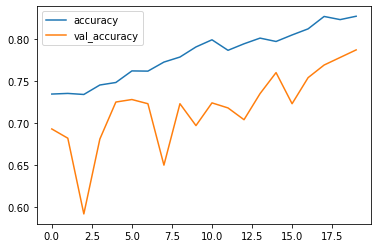

In [60]:
import pandas as pd
df=pd.DataFrame(history.history)
ax = df[['accuracy', 'val_accuracy']].plot()

### Avaliar a função de perda

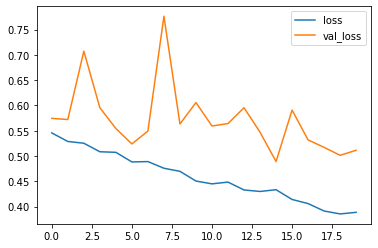

In [61]:
#Vamos analisar a taxa de aprendizagem
#De modo simplificado, uma função de perda, representa a distância entre o previsto e o real.
#Quanto menor melhor.
ax = df[['loss', 'val_loss']].plot()

In [62]:
from keras.models import Model, model_from_json

In [63]:
#Salvar a rede neural
classificador_json = classifier.to_json()
with open('classificador_cnn_cat_dog.json', 'w') as json_file:
    json_file.write(classificador_json)
classifier.save_weights('classificador_cnn_cat_dog.h5')

In [64]:
#Carregar
arquivo = open('classificador_cnn_cat_dog.json', 'r')
estrutura_rede = arquivo.read()
arquivo.close()

classifier = model_from_json(estrutura_rede)
classifier.load_weights('classificador_cnn_cat_dog.h5')

### Fazendo Previsões

In [65]:
import numpy as np
from keras.preprocessing import image

In [88]:
#imagem_teste = image.load_img('dataset/test_set/cachorro/dog.3500.jpg',target_size = (64,64))
imagem_teste = image.load_img('dataset/test_set/gato/cat.3505.jpg', target_size = (64,64))

In [89]:
#Converter para pixel
imagem_teste = image.img_to_array(imagem_teste)
imagem_teste

array([[[ 41.,  49.,  52.],
        [ 22.,  30.,  33.],
        [ 26.,  34.,  37.],
        ...,
        [ 23.,  35.,  57.],
        [ 35.,  46.,  66.],
        [ 30.,  37.,  55.]],

       [[ 32.,  39.,  47.],
        [ 23.,  30.,  38.],
        [ 25.,  32.,  40.],
        ...,
        [ 30.,  42.,  64.],
        [ 34.,  45.,  65.],
        [ 32.,  39.,  57.]],

       [[ 33.,  40.,  50.],
        [ 32.,  39.,  49.],
        [ 33.,  40.,  50.],
        ...,
        [ 48.,  60.,  82.],
        [ 39.,  50.,  70.],
        [ 31.,  38.,  56.]],

       ...,

       [[105.,  95.,  86.],
        [ 58.,  41.,  33.],
        [ 99.,  78.,  57.],
        ...,
        [126.,  99.,  88.],
        [131., 100.,  79.],
        [179., 137., 113.]],

       [[ 85.,  66.,  51.],
        [ 73.,  50.,  36.],
        [102.,  78.,  52.],
        ...,
        [ 77.,  54.,  38.],
        [112.,  85.,  58.],
        [173., 134., 105.]],

       [[139., 115.,  91.],
        [115.,  94.,  77.],
        [108.,  

In [90]:
#Normalização
imagem_teste /= 255
imagem_teste

array([[[0.16078432, 0.19215687, 0.20392157],
        [0.08627451, 0.11764706, 0.12941177],
        [0.10196079, 0.13333334, 0.14509805],
        ...,
        [0.09019608, 0.13725491, 0.22352941],
        [0.13725491, 0.18039216, 0.25882354],
        [0.11764706, 0.14509805, 0.21568628]],

       [[0.1254902 , 0.15294118, 0.18431373],
        [0.09019608, 0.11764706, 0.14901961],
        [0.09803922, 0.1254902 , 0.15686275],
        ...,
        [0.11764706, 0.16470589, 0.2509804 ],
        [0.13333334, 0.1764706 , 0.25490198],
        [0.1254902 , 0.15294118, 0.22352941]],

       [[0.12941177, 0.15686275, 0.19607843],
        [0.1254902 , 0.15294118, 0.19215687],
        [0.12941177, 0.15686275, 0.19607843],
        ...,
        [0.1882353 , 0.23529412, 0.32156864],
        [0.15294118, 0.19607843, 0.27450982],
        [0.12156863, 0.14901961, 0.21960784]],

       ...,

       [[0.4117647 , 0.37254903, 0.3372549 ],
        [0.22745098, 0.16078432, 0.12941177],
        [0.3882353 , 0

In [91]:
#Colocar no formato que o tensorflow trabalha com as imagens
imagem_teste = np.expand_dims(imagem_teste, axis = 0)

In [93]:
previsao = classifier.predict(imagem_teste)
previsao

array([[0.20799133]], dtype=float32)

In [94]:
base_treinamento.class_indices

{'cachorro': 0, 'gato': 1}

In [95]:
previsao = (previsao > 0.5)
previsao

array([[False]])

In [96]:
if previsao == True :
    prediction = 'Gato'
else:
    prediction = 'Cachorro'
prediction

'Cachorro'

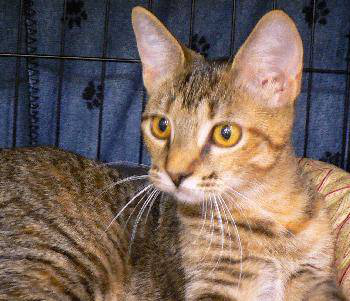

In [97]:
from IPython.display import display
from PIL import Image
#img = Image.open('dataset/test_set/cachorro/dog.3500.jpg')
img = Image.open('dataset/test_set/gato/cat.3505.jpg')
display(img)

### Referências
* Visualize Model Training History in Keras. Disponível em: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/. Acesso em 14/11/2022.
* Perceptron. Disponível em: https://www.deeplearningbook.com.br/?s=Perceptron. Acesso em 31/10/2022.
* Formação Cientista de Dados com Python e R. Disponível em:< https://www.udemy.com/course/cientista-de-dados/>. Acesso em 01/02/2020;
* Deep Learning com Python de A a Z - O Curso Completo. Disponível em:https://www.udemy.com/course/deep-learning-com-python-az-curso-completo/learn/lecture/10715306?start=57#overview. Acesso em 31/10/2022.
* UCI - machine learning repositor. Disponível em:https://archive.ics.uci.edu/ml/index.php. Acesso em 31/10/2022.
* Keras. Disponível em: https://keras.io/. Acesso em 31/10/2022.
* Capítulo 47 – Reconhecimento de Imagens com Redes Neurais Convolucionais em Python – Parte 4. Disponível em: https://www.deeplearningbook.com.br/?s=redes+neurais+convolucionais. Acesso em 01/11/2022.
* Keras optimizers. Disponível em: https://keras.io/api/optimizers/. Acesso em 25/05/2023.